# Multi-Compartment Microscopic Diffusion Imaging

The recently proposed Multi-Compartment Microscopic Diffusion Imaging (MC-MDI) model *(Kaden et al. 2016)* is a spherical convolution-based technique, which separates intra- from extra-axonal diffusion inside the spherical convolution kernel as

$$
\begin{align}
\begin{aligned}
 E_{\textrm{MC-SMT}}= \overbrace{\operatorname{FOD}}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\left[\underbrace{f_r\overbrace{E_r(\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}+\underbrace{(1-f_r)\overbrace{E_h(\lambda_\parallel|\lambda_\perp^{\textrm{tort}})}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}\right].
\end{aligned}
\end{align}$$

The formulation of MC-MDI finds similarities in models such as NODDI, but stands apart in only considering the spherical mean of the signal at every acquisition shell, as used in the Spherical Mean Technique (SMT) *(Kaden et al. 2015)*.

SMT observes that if the FOD is a probability density (i.e. integrated to unity) then spherical mean of the signal and the convolution kernel must be the same
\begin{equation}
\int_{\mathbb{S}^2}E_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}(\operatorname{FOD}\,*_{\mathbb{S}^2}\,K)_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}K_b(\textbf{g})d\textbf{g}=\epsilon_K(b,\lambda_\perp,\lambda_\parallel).
\end{equation}
The estimation of the multi-compartment kernel using SMT enables the characterization of per-axon micro-environments, as the effects of axon dispersion and crossings are only contained in the FOD.

Advantages:
- Insensitive to axon dispersion and crossings.

Limitations:
- Biased in the presence of non-white matter tissues (CSF)
- Only accounts for average of tissue properties in crossing configurations, which potentially each have different properties.
- Assumes Tortuosity constraint on perpendicular diffusivity.
- Assumes parallel diffusivity of intra- and extra-axonal compartments are the same.

# Using Dmipy to set up the MC-SMT Model
To set up the MC-MDI model in dmipy is straightforward. First, we call the basic Stick and Zeppelin components of the model:

In [1]:
from dmipy.signal_models import cylinder_models, gaussian_models
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()

As we will be imposing a tortuosity constraint, we cannot just give these models to the MultiCompartmentSphericalMeanModel directly. First we must create a `BundleModel`, which will act like a 2nd level distributed model in which we can impose tortuosity and the other parameter links:

In [2]:
from dmipy.distributions.distribute_models import BundleModel
bundle = BundleModel([stick, zeppelin])
bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp',
    'C1Stick_1_lambda_par','partial_volume_0')
bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')

We can then go ahead and and create our MC-MDI model with the bundle model as input.

In [3]:
from dmipy.core import modeling_framework
mcdmi_mod = modeling_framework.MultiCompartmentSphericalMeanModel(
    models=[bundle])
mcdmi_mod.parameter_names

We highly recommend installing pathos to take advantage of multicore processing.


['BundleModel_1_partial_volume_0', 'BundleModel_1_G2Zeppelin_1_lambda_par']

Calling MultiCompartmentSphericalMeanModel instead of MultiCompartmentModel will automatically fit the spherical mean of the model to the spherical mean of the signal, rather than the regular fitting of separate DWIs to the model.

Setting MC-MDI's tortuosity constraint and parallel diffusivity equality is the same as in the previous NODDI models.

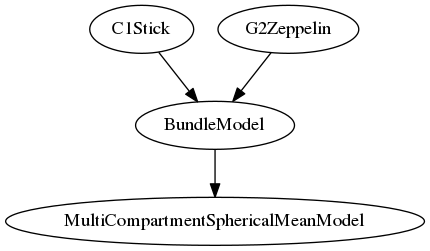

In [4]:
from IPython.display import Image
mcdmi_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

## Fitting MC-SMT to Human Connectome Project data

In [5]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()
sub_image = data_hcp[70:90,: , 70:90]

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


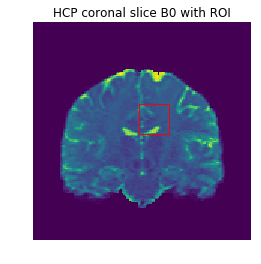

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

In [7]:
# Fitting a spherical mean model is again very fast.
mcdmi_fit_hcp = mcdmi_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Setup brute2fine optimizer in 3.02623414993 seconds
Fitting of 8181 voxels complete in 70.9273750782 seconds.
Average of 0.00866976837528 seconds per voxel.


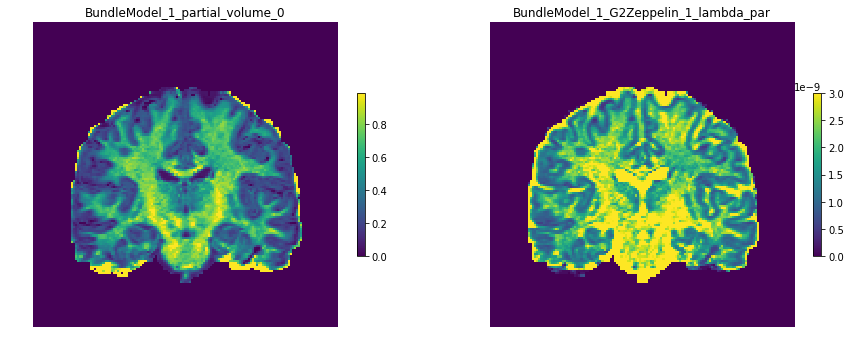

In [8]:
fitted_parameters = mcdmi_fit_hcp.fitted_parameters

fig, axs = plt.subplots(1, len(fitted_parameters), figsize=[15, 15])
axs = axs.ravel()

for i, (name, values) in enumerate(fitted_parameters.items()):
    cf = axs[i].imshow(values.squeeze().T, origin=True)
    axs[i].set_title(name)
    axs[i].set_axis_off()
    fig.colorbar(cf, ax=axs[i], shrink=0.2)

## Estimating CSD FODs using Voxel-Varying Spherical Mean Kernel

Aside from parametric FODs (see spherical mean example), Dmipy allows for the estimation of Spherical Harmonics Fiber Orientation Distributions (FODs) using the fitted spherical mean model parameters as a convolution kernel.

During the estimation of the FODs the parameters of the kernel are fixed to those estimated during the spherical mean step.

\begin{align}
 E^{\textrm{MCMDI-CSD
}}= \overbrace{\operatorname{FOD}(\textbf{c})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\, \left[\underbrace{f_h\overbrace{E_{\textrm{h}}(\cdot|\lambda_\perp^{\textrm{tort}},\lambda_\parallel)}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}+\underbrace{f_r\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}\right].
\end{align}

### CSD FOD Estimation from spherical mean model
As model definitions are generalized in Dmipy, we can instantiate the MC-SH model using the same `BundleModel` with which we instantiated the MC-SM model.

We highly recommend installing pathos to take advantage of multicore processing.


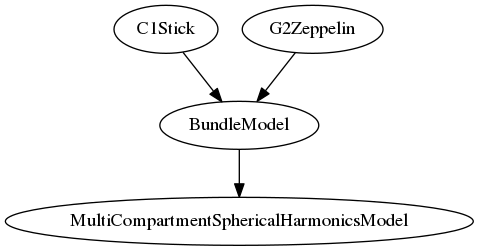

In [10]:
mcmdi_csd_mod = modeling_framework.MultiCompartmentSphericalHarmonicsModel(
    models=[bundle])

from IPython.display import Image
mcmdi_csd_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

As the model composition is the same (and thus the parameter naming) we can **directly** set the kernel parameters of the MC-SH model using the fitted output of the MCMDI model we just fitted.

In [11]:
for name, value in mcdmi_fit_hcp.fitted_parameters.items():
    mcmdi_csd_mod.set_fixed_parameter(name, value)

We then fit the same data again, but now using our new MC-SH model with fixed, voxel-varying kernel parameters

In [12]:
mcmdi_csd_fit = mcmdi_csd_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Setup Tournier07 FOD optimizer in 0.00954580307007 seconds
Fitting of 8181 voxels complete in 262.711626053 seconds.
Average of 0.0321124099808 seconds per voxel.


### Spherical Harmonics FOD visualization

In [13]:
from dipy.data import get_sphere
from dipy.viz import window, actor
sphere = get_sphere(name='symmetric724').subdivide()
fods = mcmdi_csd_fit.fod(sphere.vertices)[70:90,: , 70:90]

In [14]:
import numpy as np
affine = np.eye(4)
volume_res = mcmdi_csd_fit.fitted_parameters['BundleModel_1_partial_volume_0'][70:90,: , 70:90]
volume_im = actor.slicer(volume_res[:, 0, :, None], interpolation='nearest', affine=affine, opacity=0.7)

In [15]:
ren = window.Renderer()
fod_spheres = actor.odf_slicer(
    fods, sphere=sphere, scale=0.9, norm=False)
fod_spheres.display_extent(0, fods.shape[0]-1, 0, fods.shape[1]-1, 0, fods.shape[2]-1)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
ren.add(fod_spheres)
ren.add(volume_im)
window.record(ren, size=[700, 700])

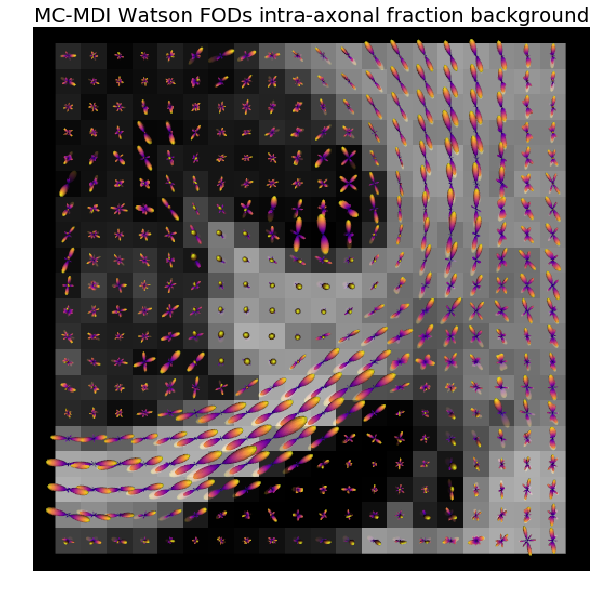

In [16]:
import matplotlib.image as mpimg
img = mpimg.imread('fury.png')

plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.title('MC-MDI Watson FODs intra-axonal fraction background', fontsize=20)
plt.axis('off');

## Estimating Error Metrics: MSE and $R^2$

It is also possible to calculate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination.  
In MSE, the lower the better, while $R^2$ ranges between 0 and 1, with 1 being a perfect model fit.

/home/rutger/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/fitted_modeling_framework.py:324: RuntimeWarning: invalid value encountered in divide


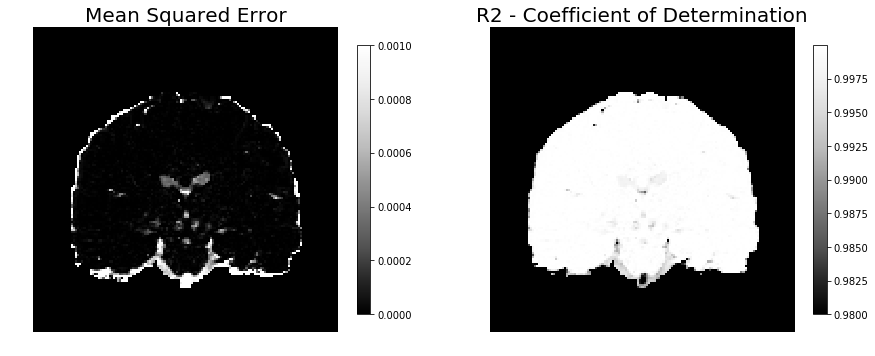

In [17]:
mse = mcdmi_fit_hcp.mean_squared_error(data_hcp)
R2 = mcdmi_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=1e-3, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
axs[0].set_axis_off()
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=.98, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20)
axs[1].set_axis_off();

The MSE shows that the fitting error is very low overall, with only slightly higher errors in the CSF and much larger errors in the skull. The $R^2$ agree with the MSE results, having values very close to 1 overall, with lower values in the CSF and skull.

## References
- Kaden, Enrico, et al. "Multi-compartment microscopic diffusion imaging." NeuroImage 139 (2016): 346-359.
- Kaden, Enrico, Frithjof Kruggel, and Daniel C. Alexander. "Quantitative mapping of the per‐axon diffusion coefficients in brain white matter." Magnetic resonance in medicine 75.4 (2016): 1752-1763.